In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Descargado de OpenData de AEMET datos para el mes de septiembre de 2018:

In [2]:
PATH_AEMET_PER_DAY = '../../data/raw/other-data/aemet_per_day.json'
PATH_BIKES = '../../data/raw/bike_data.csv'

In [3]:
df_weather = pd.read_json(PATH_AEMET_PER_DAY, orient='records')

In [28]:
df_weather.head()

,date,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin,weather_date
0,2018-09-01,3195,"MADRID, RETIRO",MADRID,667,"27,3","0,0","21,0",06:50,"33,6",13:40,4,"1,1","7,5",01:50,"943,4",10,"939,2",19,2018-09-01
1,2018-09-02,3195,"MADRID, RETIRO",MADRID,667,"27,5","1,2","20,2",22:10,"34,8",14:30,34,"1,7","9,2",22:40,"942,4",08,"937,0",18,2018-09-02
2,2018-09-03,3195,"MADRID, RETIRO",MADRID,667,"26,8","0,0","22,3",06:10,"31,3",14:50,11,"1,7","7,8",03:40,"937,5",10,"933,7",16,2018-09-03
3,2018-09-04,3195,"MADRID, RETIRO",MADRID,667,"24,4","0,0","19,4",06:20,"29,5",13:30,18,"1,4","6,9",15:20,"938,5",08,"934,6",17,2018-09-04
4,2018-09-05,3195,"MADRID, RETIRO",MADRID,667,"23,0","0,0","18,3",05:10,"27,8",13:40,25,"2,8","10,0",19:30,"939,6",09,"936,6",18,2018-09-05


Sólo vamos a emplear el viento, las precipitaciones y la temperatura. Aemet sólo nos proporciona la información diaria, no horaria. Para la predicción de la demanda horaria, necesitamos estimar los valores de estas magnitudes por horaria:
- Para el viento, asumimos esa velocidad media para todo el día. 
- Para las precipitaciones:
    - Decidir si distribuir esas precipitaciones a lo largo del día (mmm no) o dejar esas precipitaciones para todo el día -> analizar si hay un comportamiento extraño
- Para la temperatura:
    - Asumir que la temperatura varía a lo largo del día n de manera lineal en los siguientes tramos:
        - [horatmin(n), tmin(n)] -> [horatmax(n), tmax(n)]
        - [horatmax(n), tmax(n)] -> [horatmax(n+1), tmax(n+1)]

In [5]:
# Predicción diaria -> valores diarios del clima

In [68]:
df_weather['weather_date'] = pd.to_datetime(df_weather['date'])

In [69]:
df_bikes = pd.read_csv(PATH_BIKES)

In [70]:
df_bikes['ride_date'] = pd.to_datetime(pd.to_datetime(df_bikes['unplug_hourTime']).dt.date)

In [71]:
df_rides_per_day = df_bikes.groupby('ride_date').size().reset_index(name='rides')

In [72]:
df_rides_per_day = df_rides_per_day.merge(df_weather, how='left', left_on='ride_date', right_on='weather_date').drop(columns='weather_date')

In [73]:
df_rides_per_day.head()

,ride_date,rides,date,indicativo,nombre,provincia,altitud,tmed,prec,tmin,...,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin
0,2018-09-01,9762,2018-09-01,3195,"MADRID, RETIRO",MADRID,667,"27,3","0,0","21,0",...,"33,6",13:40,4,"1,1","7,5",01:50,"943,4",10,"939,2",19
1,2018-09-02,9882,2018-09-02,3195,"MADRID, RETIRO",MADRID,667,"27,5","1,2","20,2",...,"34,8",14:30,34,"1,7","9,2",22:40,"942,4",08,"937,0",18
2,2018-09-03,14631,2018-09-03,3195,"MADRID, RETIRO",MADRID,667,"26,8","0,0","22,3",...,"31,3",14:50,11,"1,7","7,8",03:40,"937,5",10,"933,7",16
3,2018-09-04,15957,2018-09-04,3195,"MADRID, RETIRO",MADRID,667,"24,4","0,0","19,4",...,"29,5",13:30,18,"1,4","6,9",15:20,"938,5",08,"934,6",17
4,2018-09-05,16058,2018-09-05,3195,"MADRID, RETIRO",MADRID,667,"23,0","0,0","18,3",...,"27,8",13:40,25,"2,8","10,0",19:30,"939,6",09,"936,6",18


In [74]:
df_rides_per_day = df_rides_per_day.drop(['date', 'indicativo', 'nombre', 'provincia', 'altitud'], axis=1)

In [75]:
day_of_week_dict = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
}

In [76]:
df_rides_per_day['day_of_week'] = df_rides_per_day['ride_date'].dt.dayofweek

In [77]:
df_rides_per_day['day_of_week'] = df_rides_per_day['day_of_week'].map(day_of_week_dict)

In [78]:
df_rides_per_day.head()

,ride_date,rides,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin,day_of_week
0,2018-09-01,9762,"27,3","0,0","21,0",06:50,"33,6",13:40,4,"1,1","7,5",01:50,"943,4",10,"939,2",19,Sat
1,2018-09-02,9882,"27,5","1,2","20,2",22:10,"34,8",14:30,34,"1,7","9,2",22:40,"942,4",08,"937,0",18,Sun
2,2018-09-03,14631,"26,8","0,0","22,3",06:10,"31,3",14:50,11,"1,7","7,8",03:40,"937,5",10,"933,7",16,Mon
3,2018-09-04,15957,"24,4","0,0","19,4",06:20,"29,5",13:30,18,"1,4","6,9",15:20,"938,5",08,"934,6",17,Tue
4,2018-09-05,16058,"23,0","0,0","18,3",05:10,"27,8",13:40,25,"2,8","10,0",19:30,"939,6",09,"936,6",18,Wed


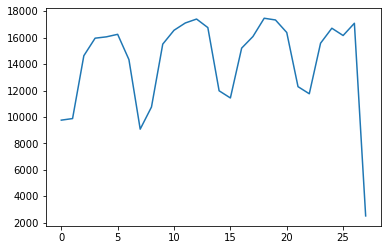

In [79]:
plt.plot(df_rides_per_day['rides'])

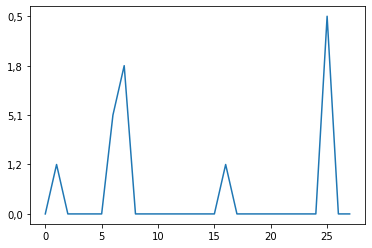

In [80]:
plt.plot(df_rides_per_day['prec'])

In [81]:
import seaborn as sns

<ipython-input-46-10808c6c33a6>:12: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f924b927910>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend((l1, l2), ('a,', 'b'))
<ipython-input-46-10808c6c33a6>:12: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f924b93bac0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend((l1, l2), ('a,', 'b'))


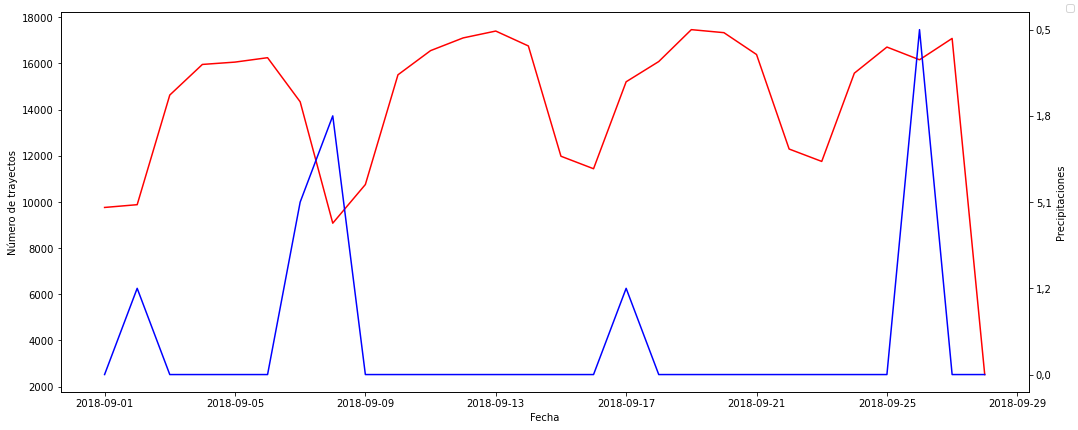

In [46]:
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Número de trayectos')
l1 = ax1.plot(df_rides_per_day['ride_date'], df_rides_per_day['rides'], color='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Precipitaciones')
l2 = ax2.plot(df_rides_per_day['ride_date'], df_rides_per_day['prec'], color='b')

handles, labels = ax1.get_legend_handles_labels()
fig.tight_layout()
fig.legend((l1, l2), ('a,', 'b'))
plt.show()

Correlación entre variables de clima y cantidad de trayectos en bici:

In [83]:
df_rides_per_day['tmed'] =  pd.to_numeric(df_rides_per_day['tmed'].str.replace(',', '.'), downcast='float')
df_rides_per_day['prec'] =  pd.to_numeric(df_rides_per_day['prec'].str.replace(',', '.'), downcast='float')
df_rides_per_day['tmin'] =  pd.to_numeric(df_rides_per_day['tmin'].str.replace(',', '.'), downcast='float')
df_rides_per_day['tmax'] =  pd.to_numeric(df_rides_per_day['tmax'].str.replace(',', '.'), downcast='float')
df_rides_per_day['velmedia'] =  pd.to_numeric(df_rides_per_day['velmedia'].str.replace(',', '.'), downcast='float')
df_rides_per_day['racha'] =  pd.to_numeric(df_rides_per_day['racha'].str.replace(',', '.'), downcast='float')
df_rides_per_day['presMax'] =  pd.to_numeric(df_rides_per_day['presMax'].str.replace(',', '.'), downcast='float')
df_rides_per_day['presMin'] =  pd.to_numeric(df_rides_per_day['presMin'].str.replace(',', '.'), downcast='float')

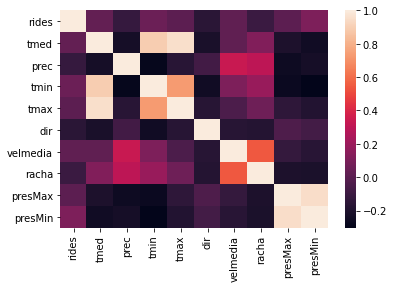

In [85]:
sns.heatmap(df_rides_per_day.corr())

No parece que la cantidad de trayectos esté íntimamente relacionada con otras de las variables de las que disponemos 